Figure 13.2: REINFORCE with Baseline

Setup:
  Episodes: 1000
  Trials: 100
  Optimal return: -11.6

[1/2] Training REINFORCE without baseline...
  Completed 20/100 trials
  Completed 40/100 trials
  Completed 60/100 trials
  Completed 80/100 trials
  Completed 100/100 trials
  Final avg return: -11.56

[2/2] Training REINFORCE with baseline...
  Completed 20/100 trials
  Completed 40/100 trials
  Completed 60/100 trials
  Completed 80/100 trials
  Completed 100/100 trials
  Final avg return: -10.90


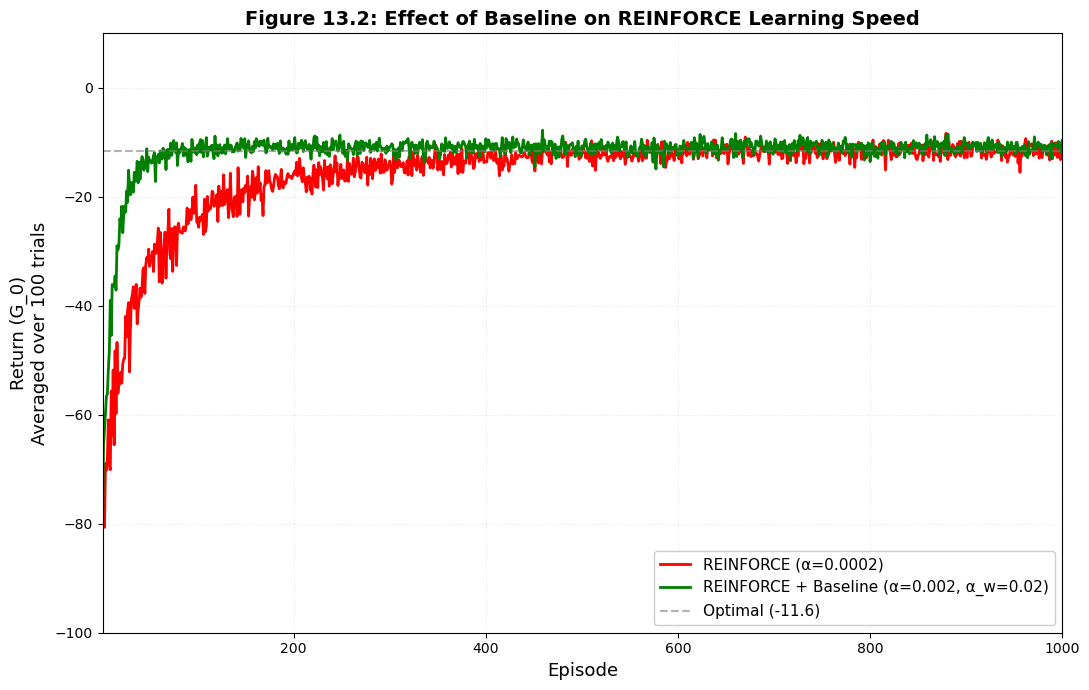

In [2]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Figure 13.2 REINFORCE vs REINFORCE with Baseline
# This is the code for the right graph of Figure 13.2 in Sutton and Barto's RL textbook
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt

class SimpleCorridorEnv:
    """
    Simple corridor gridworld with state 1 having reversed action effects.
    
    States: 0 (start), 1, 2, 3 (terminal)
    Normal state mechanics: right increases state, left decreases
    State 1 exception: right decreases, left increases (asymmetry!)
    """
    
    def __init__(self):
        self.state = 0
    
    def reset(self):
        """Reset to starting state"""
        self.state = 0
    
    def take_action(self, action_is_right):
        """
        Execute one action step.
        
        Args:
            action_is_right (bool): True for right action, False for left
        
        Returns:
            reward (int): -1 for each step, 0 when done
            is_done (bool): True if reached terminal state (state 3)
        """
        
        # States 0 and 2 have normal action effects
        if self.state == 0 or self.state == 2:
            if action_is_right:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)
        
        # State 1 has reversed action effects (the asymmetry)
        elif self.state == 1:
            if action_is_right:
                self.state -= 1  # right actually goes left!
            else:
                self.state += 1  # left actually goes right!
        
        # Check if terminal
        if self.state == 3:
            return 0, True  # terminal reward is 0
        else:
            return -1, False  # step penalty
        
class PolicyGradientAgent:
    """
    REINFORCE agent with optional learned baseline.
    
    Features softmax policy parameterized with linear preference function:
        h = theta^T * x(state)
        pi(action|state) = softmax(h)
    
    where x represents actions as one-hot features.
    """
    
    def __init__(self, step_size_policy, discount=1.0, step_size_baseline=None):
        """
        Initialize the agent.
        
        Args:
            step_size_policy (float): Alpha for policy parameter updates
            discount (float): Gamma (discount factor)
            step_size_baseline (float): Alpha_w for baseline updates (optional)
        """
        # Policy parameters theta (one for each action)
        self.theta = np.array([-1.47, 1.47])
        
        # Feature matrix: rows=states, cols=actions
        # Each state has one-hot action features
        self.features = np.array([
            [0, 1],  # state 0: [left_feature, right_feature]
            [1, 0]   # state 1: [left_feature, right_feature]
        ])
        
        self.step_size_policy = step_size_policy
        self.discount = discount
        self.step_size_baseline = step_size_baseline if step_size_baseline else 0
        self.has_baseline = step_size_baseline is not None
        
        # Learned state value baseline
        self.baseline_value = 0.0
        
        # Store trajectory for learning
        self.episode_rewards = []
        self.episode_actions = []
    
    def compute_policy(self):
        """
        Compute action probabilities using softmax.
        
        Returns:
            pmf (array): [prob_left, prob_right]
        """
        # Compute preferences: h = theta^T * features
        h = np.dot(self.theta, self.features)
        
        # Softmax with numerical stability
        h_stable = h - np.max(h)
        exp_h = np.exp(h_stable)
        pmf = exp_h / np.sum(exp_h)
        
        # Ensure exploration (never fully deterministic)
        epsilon = 0.05
        min_idx = np.argmin(pmf)
        if pmf[min_idx] < epsilon:
            pmf[:] = 1.0 - epsilon
            pmf[min_idx] = epsilon
        
        return pmf
    
    def select_action(self, step_reward):
        """
        Select action according to policy and record step.
        
        Args:
            step_reward (float or None): Reward from previous step
        
        Returns:
            action_is_right (bool): Action choice
        """
        if step_reward is not None:
            self.episode_rewards.append(step_reward)
        
        pmf = self.compute_policy()
        action_is_right = np.random.uniform() < pmf[1]
        self.episode_actions.append(action_is_right)
        
        return action_is_right
    
    def learn_from_episode(self, final_reward):
        """
        Update parameters after episode completes.
        
        Args:
            final_reward (float): Final step reward
        """
        self.episode_rewards.append(final_reward)
        
        # Compute returns G_t (backward from episode end)
        num_steps = len(self.episode_rewards)
        returns = np.zeros(num_steps)
        returns[-1] = self.episode_rewards[-1]
        
        for step_idx in range(num_steps - 2, -1, -1):
            returns[step_idx] = self.episode_rewards[step_idx] + self.discount * returns[step_idx + 1]
        
        # Update parameters for each step
        discount_power = 1.0
        
        for step_idx in range(num_steps):
            action_idx = 1 if self.episode_actions[step_idx] else 0
            return_t = returns[step_idx]
            
            pmf = self.compute_policy()
            
            # Score function gradient: nabla log pi(a|s) = x(a) - E[x]
            score_grad = self.features[:, action_idx] - np.dot(self.features, pmf)
            
            if self.has_baseline:
                # Advantage: return minus baseline
                advantage = return_t - self.baseline_value
                
                # Update baseline: w <- w + alpha_w * gamma^t * (G_t - w)
                self.baseline_value += self.step_size_baseline * discount_power * advantage
                
                # Update policy: theta <- theta + alpha * gamma^t * advantage * nabla_log_pi
                self.theta += self.step_size_policy * discount_power * advantage * score_grad
            else:
                # No baseline: update only on return
                self.theta += self.step_size_policy * discount_power * return_t * score_grad
            
            discount_power *= self.discount
        
        # Clear trajectory
        self.episode_rewards = []
        self.episode_actions = []

def run_single_trial(num_episodes, make_agent):
    """
    Execute one complete trial of training.
    
    Args:
        num_episodes (int): Episodes to train
        make_agent (callable): Factory function to create agent
    
    Returns:
        episode_returns (array): Total return for each episode
    """
    env = SimpleCorridorEnv()
    agent = make_agent()
    episode_returns = np.zeros(num_episodes)
    
    for ep in range(num_episodes):
        env.reset()
        total_return = 0
        step_reward = None
        
        # Run episode
        while True:
            action = agent.select_action(step_reward)
            step_reward, done = env.take_action(action)
            total_return += step_reward
            
            if done:
                agent.learn_from_episode(step_reward)
                break
        
        episode_returns[ep] = total_return
    
    return episode_returns


def run_multiple_trials(num_episodes, num_trials, make_agent):
    """
    Execute multiple independent trials.
    
    Args:
        num_episodes (int): Episodes per trial
        num_trials (int): Number of independent trials
        make_agent (callable): Factory function to create agent
    
    Returns:
        all_returns (array): Shape (num_trials, num_episodes)
    """
    all_returns = np.zeros((num_trials, num_episodes))
    
    for trial_num in range(num_trials):
        all_returns[trial_num] = run_single_trial(num_episodes, make_agent)
        
        if (trial_num + 1) % 20 == 0:
            print(f"  Completed {trial_num + 1}/{num_trials} trials")
    
    return all_returns


# Experiment configuration
num_total_episodes = 1000
num_total_trials = 100
gamma = 1.0

print("=" * 70)
print("Figure 13.2: REINFORCE with Baseline")
print("=" * 70)
print(f"\nSetup:")
print(f"  Episodes: {num_total_episodes}")
print(f"  Trials: {num_total_trials}")
print(f"  Optimal return: -11.6")

print("\n[1/2] Training REINFORCE without baseline...")
alpha_no_baseline = 2e-4

def create_agent_no_baseline():
    return PolicyGradientAgent(
        step_size_policy=alpha_no_baseline,
        discount=gamma,
        step_size_baseline=None
    )

returns_no_baseline = run_multiple_trials(
    num_total_episodes, 
    num_total_trials, 
    create_agent_no_baseline
)

mean_no_baseline = returns_no_baseline.mean(axis=0)
print(f"  Final avg return: {mean_no_baseline[-100:].mean():.2f}")

print("\n[2/2] Training REINFORCE with baseline...")
alpha_with_baseline = 2e-3
alpha_baseline_step = 2e-2

def create_agent_with_baseline():
    return PolicyGradientAgent(
        step_size_policy=alpha_with_baseline,
        discount=gamma,
        step_size_baseline=alpha_baseline_step
    )

returns_with_baseline = run_multiple_trials(
    num_total_episodes, 
    num_total_trials, 
    create_agent_with_baseline
)

mean_with_baseline = returns_with_baseline.mean(axis=0)
print(f"  Final avg return: {mean_with_baseline[-100:].mean():.2f}")

# Create the figure
fig, ax = plt.subplots(figsize=(11, 7))

episodes = np.arange(1, num_total_episodes + 1)

# Plot results
ax.plot(episodes, mean_no_baseline, 'r-', linewidth=2.0, 
        label=f'REINFORCE (α={alpha_no_baseline})')
ax.plot(episodes, mean_with_baseline, 'g-', linewidth=2.0,
        label=f'REINFORCE + Baseline (α={alpha_with_baseline}, α_w={alpha_baseline_step})')

# Optimal value line
ax.axhline(y=-11.6, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, label='Optimal (-11.6)')

# Formatting
ax.set_xlabel('Episode', fontsize=13)
ax.set_ylabel('Return (G_0)\nAveraged over 100 trials', fontsize=13)
ax.set_title('Figure 13.2: Effect of Baseline on REINFORCE Learning Speed', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle=':')
ax.legend(fontsize=11, loc='lower right', framealpha=0.95)
ax.set_ylim([-100, 10])
ax.set_xlim([1, num_total_episodes])

plt.tight_layout()
plt.show()

